In [1]:
!pip install geopandas rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.8 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from rasterio import features
import rasterio
from shapely.geometry import mapping
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load California shapefile
shapefile_path = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/California_Shapefile/California.shp'
ca_shapefile = gpd.read_file(shapefile_path)

# Display the first few rows to verify
print(ca_shapefile.head())

   OBJECTID  ID        NAME ST_ABBREV  TOTPOP_CY  RATE_POP  POPGRW00CY  \
0        19  18  California        CA   37983948       1.3        1.12   

   POPGRWCYFY     LANDAREA     Pop2011  Shape_Leng  Shape_Area  \
0         0.7  155959.3385  38249800.0   46.561392   41.660869   

                                            geometry  
0  MULTIPOLYGON (((-114.633 35.00208, -114.63437 ...  


### River

In [5]:
import zipfile
import os

# Path to your uploaded data and shapefile
zip_path = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/HydroRIVERS_v10_na.gdb.zip'
extracted_folder = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

import geopandas as gpd

# Set the path to the extracted GDB folder
data_path = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/HydroRIVERS_v10_na.gdb'


# Load the rivers layer from GDB
layer_name = 'HydroRIVERS_v10_na'
rivers_layer = gpd.read_file(data_path, driver='FileGDB', layer='HydroRIVERS_v10_na')

# Display the first few rows to verify
print(rivers_layer.head())



/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:196: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(


   HYRIV_ID  NEXT_DOWN  MAIN_RIV  LENGTH_KM  DIST_DN_KM  DIST_UP_KM  \
0  70000001          0  70000001       1.72         0.0         5.6   
1  70000002          0  70000002       3.38         0.0         8.3   
2  70000003          0  70000003       1.94         0.0         7.8   
3  70000004          0  70000004       1.12         0.0         8.5   
4  70000005          0  70000005       5.95         0.0        10.1   

   CATCH_SKM  UPLAND_SKM  ENDORHEIC  DIS_AV_CMS  ORD_STRA  ORD_CLAS  ORD_FLOW  \
0      14.99   13.900000          0       0.121         1         1         7   
1      25.74   24.700001          0       0.196         1         1         7   
2      13.76   13.700000          0       0.160         1         1         7   
3      10.41   10.300000          0       0.116         1         1         7   
4      21.01   20.700001          0       0.242         1         1         7   

      HYBAS_L12  Shape_Length  \
0  7.120027e+09      0.018035   
1  7.120027e+09     

In [6]:
# Ensure both datasets have the same CRS
rivers_layer = rivers_layer.to_crs(ca_shapefile.crs)

# Perform spatial intersection with California shapefile
rivers_in_ca = gpd.overlay(rivers_layer, ca_shapefile, how='intersection')

# Display the first few rows to verify
print(rivers_in_ca.head())


   HYRIV_ID  NEXT_DOWN  MAIN_RIV  LENGTH_KM  DIST_DN_KM  DIST_UP_KM  \
0  70514413   70514414  70528273       2.42  284.600006   10.800000   
1  70514414   70515308  70528273       0.34  284.100006   11.400000   
2  70514415   70515308  70528273       2.31  284.299988    9.000000   
3  70514416   70515448  70528273       5.59  291.500000    9.900000   
4  70514417   70515448  70528273      12.81  291.500000   47.700001   

   CATCH_SKM  UPLAND_SKM  ENDORHEIC  DIS_AV_CMS  ...  ST_ABBREV  TOTPOP_CY  \
0   4.150000   37.299999          0       0.421  ...         CA   37983948   
1   0.320000   49.400002          0       0.562  ...         CA   37983948   
2   3.190000   40.599998          0       0.449  ...         CA   37983948   
3  27.420000   27.400000          0       0.323  ...         CA   37983948   
4  44.619999  518.200012          0       6.104  ...         CA   37983948   

   RATE_POP  POPGRW00CY  POPGRWCYFY     LANDAREA     Pop2011 Shape_Leng  \
0       1.3        1.12      

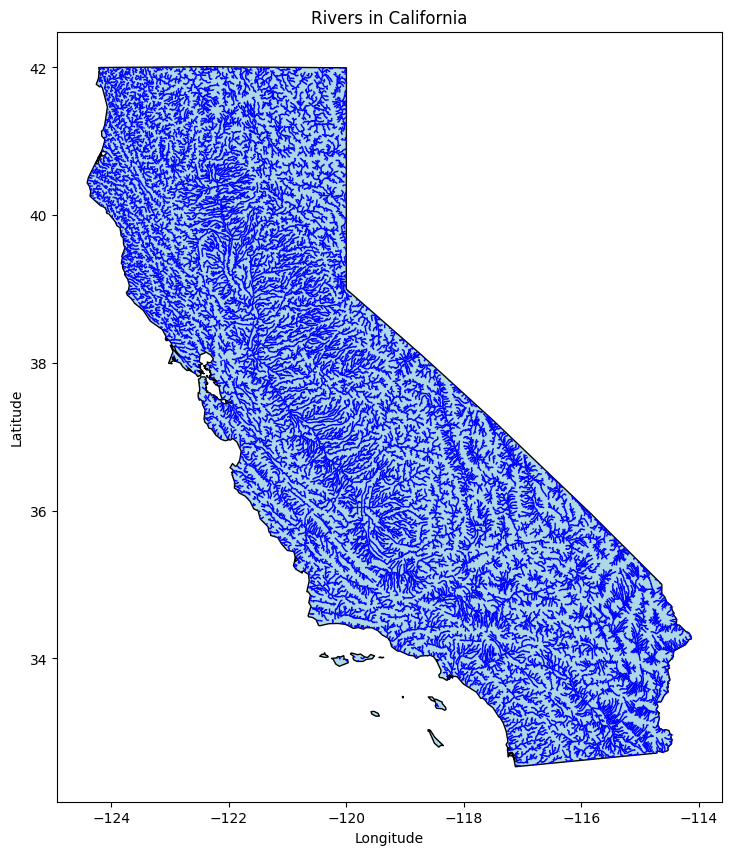

In [7]:
# Raster File
import matplotlib.pyplot as plt
# Output path for the TIFF map
output_tiff = '/content/drive/MyDrive/EE ML PFAS/Raster_Data/Mapping/WaterWays/Raster file/Rivers_in_California.tif'

# Get the bounding box from the CA shapefile
bbox = ca_shapefile.total_bounds

# Define a function to create the TIFF map using rasterio
def create_tiff(data, output_path, bbox, width=1000, height=1000):
    transform = rasterio.transform.from_bounds(*bbox, width, height)
    out_shape = (height, width)

    # Initialize the output array
    out_image = rasterio.features.rasterize(
        [(mapping(geom), 1) for geom in data.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    with rasterio.open(output_path, 'w', driver='GTiff',
                       height=out_shape[0], width=out_shape[1],
                       count=1, dtype='uint8',
                       crs=data.crs, transform=transform) as dst:
        dst.write(out_image, 1)

create_tiff(rivers_in_ca, output_tiff, bbox)


fig, ax = plt.subplots(figsize=(10, 10))
ca_shapefile.plot(ax=ax, color='lightblue', edgecolor='black')
rivers_in_ca.plot(ax=ax, color='blue', linewidth=1)
plt.title('Rivers in California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### Lake

In [8]:
import zipfile
import os

# Path to your uploaded data and shapefile
lake_zip_path = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/HydroLAKES_polys_v10.gdb.zip'
lake_extracted_folder = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/'

# Extract the contents of the ZIP file
with zipfile.ZipFile(lake_zip_path, 'r') as zip_ref:
    zip_ref.extractall(lake_extracted_folder)

import geopandas as gpd

# Set the path to the extracted GDB folder
lake_data_path = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/HydroLAKES_polys_v10.gdb'


# Load the rivers layer from GDB
lake_layer = gpd.read_file(lake_data_path, driver='FileGDB', layer='HydroLAKES_polys_v10')

# Display the first few rows to verify
print(lake_layer.head())

# # List all layers in the GDB
# gdb_layers = fiona.listlayers(lake_data_path)
# print("Layers in GDB:", gdb_layers)

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:196: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


   Hylak_id    Lake_name                   Country      Continent Poly_src  \
0         1  Caspian Sea                    Russia         Europe     SWBD   
1         2   Great Bear                    Canada  North America   CanVec   
2         3  Great Slave                    Canada  North America   CanVec   
3         4     Winnipeg                    Canada  North America   CanVec   
4         5     Superior  United States of America  North America     SWBD   

   Lake_type  Grand_id      Lake_area     Shore_len  Shore_dev  ...  \
0          1         0  377001.906250  15829.370117       7.27  ...   
1          1         0   30450.640625   5331.720215       8.62  ...   
2          1         0   26734.289062   9814.160156      16.93  ...   
3          3       709   23923.039062   4018.320068       7.33  ...   
4          1         0   81843.921875   5248.359863       5.18  ...   

       Dis_avg       Res_time  Elevation  Slope_100     Wshd_area   Pour_long  \
0  8110.642090  107883.

In [9]:
# Ensure both datasets have the same CRS
lake_layer = lake_layer.to_crs(ca_shapefile.crs)

# Perform spatial intersection with California shapefile
lakes_in_ca = gpd.overlay(lake_layer, ca_shapefile, how='intersection')

# Display the first few rows to verify
print(lakes_in_ca.head())


   Hylak_id    Lake_name                   Country      Continent Poly_src  \
0       779               United States of America  North America     SWBD   
1       780   Goose Lake  United States of America  North America    Other   
2       786  Shasta Lake  United States of America  North America     SWBD   
3       787   Eagle Lake  United States of America  North America     SWBD   
4       789   Honey Lake  United States of America  North America     SWBD   

   Lake_type  Grand_id   Lake_area   Shore_len  Shore_dev  ...  ST_ABBREV  \
0          1         0  137.690002   56.380001       1.36  ...         CA   
1          1         0  427.910004  127.440002       1.74  ...         CA   
2          2       132  102.470001  364.269989      10.15  ...         CA   
3          1         0  100.730003   87.190002       2.45  ...         CA   
4          1         0  266.100006  134.130005       2.32  ...         CA   

   TOTPOP_CY  RATE_POP  POPGRW00CY  POPGRWCYFY     LANDAREA     Pop2

**Raster File**

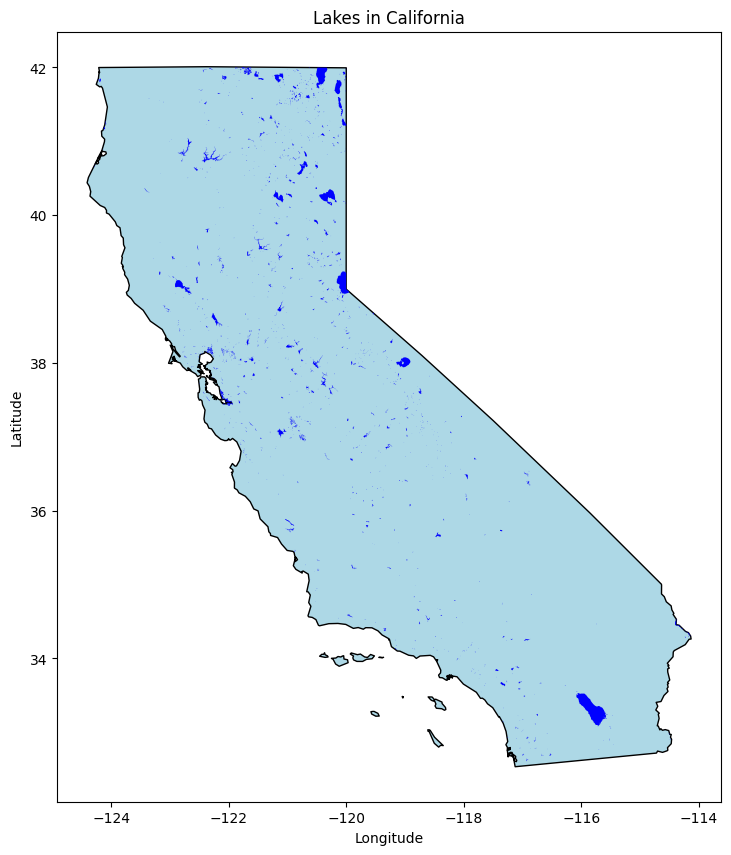

In [11]:
# Raster File
import matplotlib.pyplot as plt
# Output path for the TIFF map
lake_output_tiff = '/content/drive/MyDrive/EE ML PFAS/Raster_Data/Mapping/WaterWays/Raster file/Lakes_in_California.tif'

# Get the bounding box from the CA shapefile
bbox = ca_shapefile.total_bounds

# Define a function to create the TIFF map using rasterio
def create_tiff(data, output_path, bbox, width=1000, height=1000):
    transform = rasterio.transform.from_bounds(*bbox, width, height)
    out_shape = (height, width)

    # Initialize the output array
    out_image = rasterio.features.rasterize(
        [(mapping(geom), 1) for geom in data.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    with rasterio.open(output_path, 'w', driver='GTiff',
                       height=out_shape[0], width=out_shape[1],
                       count=1, dtype='uint8',
                       crs=data.crs, transform=transform) as dst:
        dst.write(out_image, 1)

create_tiff(lakes_in_ca, lake_output_tiff, bbox)


fig, ax = plt.subplots(figsize=(10, 10))
ca_shapefile.plot(ax=ax, color='lightblue', edgecolor='black')
lakes_in_ca.plot(ax=ax, color='blue', linewidth=1)
plt.title('Lakes in California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Basins

In [12]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Path to the folder containing the shapefiles
basin_folder_path = '/content/drive/MyDrive/EE ML PFAS/Raw_Data/Mapping/Waterways/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev01-12_v1c'

# List all shapefiles in the directory
shapefile_list = [f for f in os.listdir(basin_folder_path) if f.endswith('.shp')]

# Load all shapefiles into a single GeoDataFrame
basin_layers = gpd.GeoDataFrame(pd.concat([gpd.read_file(os.path.join(basin_folder_path, shp)) for shp in shapefile_list], ignore_index=True))

# Display the first few rows to verify
print(basin_layers.head())


     HYBAS_ID  NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  7010000010          0  7010000010  7010000010        0.0        0.0   
1  7020000010          0  7020000010  7020000010        0.0        0.0   
2  7020014250          0  7020014250  7020014250        0.0        0.0   
3  7020021430          0  7020021430  7020021430        0.0        0.0   
4  7020024600          0  7020024600  7020024600        0.0        0.0   

     SUB_AREA     UP_AREA  PFAF_ID SIDE  LAKE  ENDO  COAST  ORDER  SORT  \
0  15922470.2  15922470.0        7    M     0     0      1      0     1   
1   2518721.7   2518721.7       77    M     0     0      1      0     1   
2   1389326.8   1389326.8       78    M     0     0      1      0     2   
3   2198595.7   2198595.7       71    M     0     0      1      0     3   
4   2944221.0   2944221.0       72    M     0     0      1      0     4   

                                            geometry  
0  MULTIPOLYGON (((-79.51389 8.90417, -79.52409 8

In [13]:
# Ensure both datasets have the same CRS
basin_layers = basin_layers.to_crs(ca_shapefile.crs)

# Perform spatial intersection with California shapefile
basins_in_ca = gpd.overlay(basin_layers, ca_shapefile, how='intersection')

# Display the first few rows to verify
print(basins_in_ca.head())


     HYBAS_ID  NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  7010000010          0  7010000010  7010000010        0.0        0.0   
1  7020000010          0  7020000010  7020000010        0.0        0.0   
2  7020014250          0  7020014250  7020014250        0.0        0.0   
3  7030008710          0  7030008710  7030008710        0.0        0.0   
4  7030008720          0  7030008720  7030008720        0.0        0.0   

     SUB_AREA     UP_AREA  PFAF_ID SIDE  ...  ST_ABBREV  TOTPOP_CY  RATE_POP  \
0  15922470.2  15922470.0        7    M  ...         CA   37983948       1.3   
1   2518721.7   2518721.7       77    M  ...         CA   37983948       1.3   
2   1389326.8   1389326.8       78    M  ...         CA   37983948       1.3   
3    661111.8    661111.8      772    M  ...         CA   37983948       1.3   
4    425940.2    425940.2      774    M  ...         CA   37983948       1.3   

   POPGRW00CY  POPGRWCYFY     LANDAREA     Pop2011 Shape_Leng Shape_Area  

**Raster File**

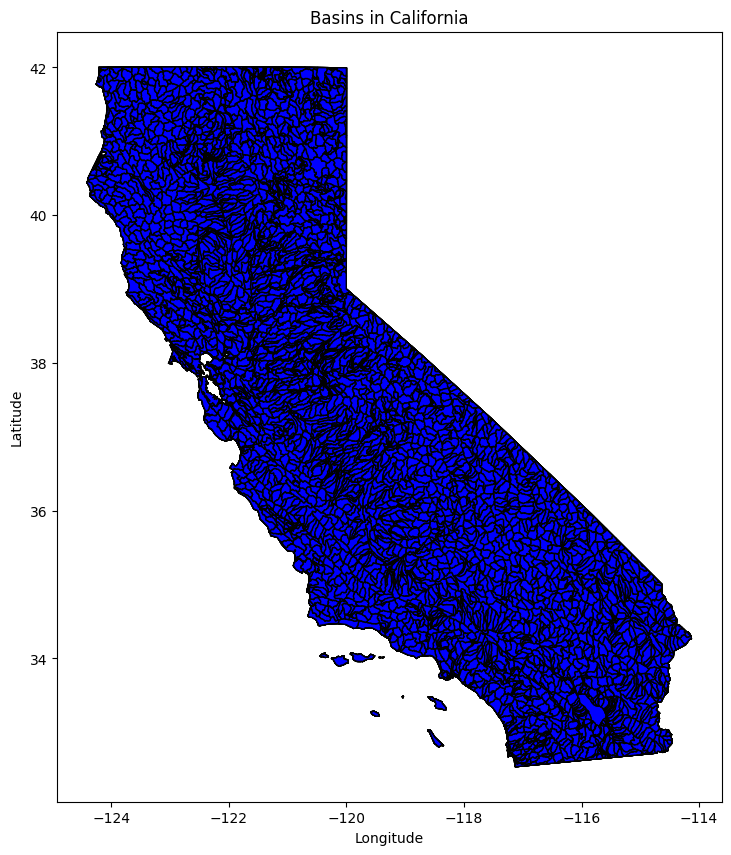

In [17]:
# Raster File
import matplotlib.pyplot as plt
# Output path for the TIFF map
basin_output_tiff = '/content/drive/MyDrive/EE ML PFAS/Raster_Data/Mapping/WaterWays/Raster file/Basins_in_California.tif'

# Get the bounding box from the CA shapefile
bbox = ca_shapefile.total_bounds

# Define a function to create the TIFF map using rasterio
def create_tiff(data, output_path, bbox, width=1000, height=1000):
    transform = rasterio.transform.from_bounds(*bbox, width, height)
    out_shape = (height, width)

    # Initialize the output array
    out_image = rasterio.features.rasterize(
        [(mapping(geom), 1) for geom in data.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    with rasterio.open(output_path, 'w', driver='GTiff',
                       height=out_shape[0], width=out_shape[1],
                       count=1, dtype='uint8',
                       crs=data.crs, transform=transform) as dst:
        dst.write(out_image, 1)

create_tiff(basins_in_ca, basin_output_tiff, bbox)


fig, ax = plt.subplots(figsize=(10, 10))
ca_shapefile.plot(ax=ax, color='lightblue', edgecolor='black')
basins_in_ca.plot(ax=ax, color='blue', edgecolor='black', linewidth=1)
plt.title('Basins in California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()